# Proximity Trees
This is an algorithm made up by Bart Goethals. It doesn't exist yet. It's bsed on another algorithm created for other purposes.

You can read section 3 of [this paper](https://arxiv.org/pdf/1808.10594.pdf) (skip 3.1).
Lucas, B., Shifaz, A., Pelletier, C., O’Neill, L., Zaidi, N., Goethals, B., ... & Webb, G. I. (2019). Proximity forest: an effective and scalable distance-based classifier for time series. Data Mining and Knowledge Discovery, 33(3), 607-635.

## The model

In [5]:
import numpy as np


class Branch:
    def __init__(self, exemplar, class_label, subtree):
        self.exemplar = exemplar  # An object, if from a node it is closest to this exemplar, it goes to given tree
        self.subtree = subtree  # Should be an internal node or a leaf node

        self.class_label = class_label  # The class label of the leaf node, not required for the algorithm, but might be useful for debuggin


class TreeNode:
    def predict(self, data):
        raise NotImplementedError()

    def print(self, depth):
        raise NotImplementedError()


class InternalNode(TreeNode):
    def __init__(self, data_x, data_y, groups, depth, max_depth, splits_to_sample):
        assert len(data_x) == len(data_y) == len(groups)
        assert len(data_x) > 0

        depth += 1

        self.measure = lambda x, y: np.linalg.norm(x - y)
        self.branches = []  # Contains internal nodes or leaf nodes

        exemplars, closest_exemplars = get_split(data_x, data_y, groups, splits_to_sample, self.measure)

        for i, exemplar in enumerate(exemplars):
            closest_data_x = data_x[closest_exemplars == i]
            closest_data_y = data_y[closest_exemplars == i]
            closest_data_groups = groups[closest_exemplars == i]

            if len(closest_data_x) == 0:
                # If everything is closer to the other one, you don't need to create a node with 0 data points
                continue

            subtree = get_node(closest_data_x, closest_data_y, closest_data_groups, depth, max_depth, splits_to_sample)
            self.branches.append(Branch(exemplar, i, subtree))  # TODO: Fix label somewhere here instead of i

    def predict(self, data):
        # Return the label of the closest subtree to the data point
        exemplar_distance = [self.measure(data, branch.exemplar) for branch in self.branches]
        closest_exemplars = get_closest_exemplars(exemplar_distance, [data], self.measure)
        branch = self.branches[closest_exemplars[0]]
        return branch.subtree.predict(data)

    def print(self, depth):
        for branch in self.branches:
            print(f"{'-' * depth}Exemplar ({branch.class_label}): " + str(branch.exemplar))
            branch.subtree.print(depth + 1)


# if all data reaching a node has the same class (node is pure), create_leaf function creates a new leaf node and assigns this class lbel to its field class
class LeafNode(TreeNode):
    def __init__(self, class_label):
        self.class_label = class_label  # This label is assigned to all data reaching this node

    def predict(self, data):
        return self.class_label

    def print(self, depth):
        print(f"{'-' * depth}Leaf ({self.class_label})")

In [6]:
# Splitting criteriaa
class ProximityTreeClassifier:
    def __init__(self, max_depth=5, num_features_to_keep=None, splits_to_sample=10):
        self.root = None
        self.max_depth = max_depth
        self.num_features_to_keep = num_features_to_keep
        self.features_to_use_indices = None
        self.splits_to_sample = splits_to_sample

    def fit(self, data_x, data_y, groups):

        self.num_features = data_x.shape[1]  # Total number of features, not the number used!!!

        self.features_to_use_indices = np.random.choice(len(data_x[0]), self.num_features_to_keep,
                                                        replace=False) if self.num_features_to_keep is not None else np.arange(
            len(data_x[0]))
        data_x_reduced = subsample_features(data_x, self.features_to_use_indices)
        # TODO: Reduce features inpredict
        self.root = get_node(data_x_reduced, data_y, groups, depth=0, max_depth=self.max_depth,
                             splits_to_sample=self.splits_to_sample)

        return self

    def predict(self, data):
        # Convert data to numpy array if not yet the case
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        # If data is 1d, add a dimension to make it 2d
        if data.ndim == 1:
            data = data[np.newaxis, :]
        assert self.root is not None, "You must fit the model before predicting"
        assert data.shape[
                   1] == self.num_features, "The number of features in the data must match the number of features in the training data"
        data_reduced = subsample_features(data, self.features_to_use_indices)
        predictions = np.apply_along_axis(self.root.predict, 1, data_reduced)
        assert predictions.shape[0] == data.shape[0], "The number of predictions must match the number of data points"
        return predictions

    def print(self):
        self.root.print(0)

In [7]:
def is_pure(data_y):
    # Check if all data has the same class label
    unique_y = np.unique(data_y)
    return len(unique_y) == 1


def get_most_common_element(array):
    return np.argmax(np.bincount(array))


def subsample_features(data_x, feature_indices):
    return data_x[:, feature_indices]


def get_node(data_x, data_y, groups, depth, max_depth, splits_to_sample):
    assert len(data_x) == len(data_y) == len(groups)
    assert len(data_x) > 0

    if is_pure(data_y) or depth >= max_depth:
        # class_label = data_y.iloc[0] # must use iloc here to get element of first row and not element at index 0
        class_label = get_most_common_element(data_y)
        return LeafNode(class_label)
    else:
        return InternalNode(data_x, data_y, groups, depth, max_depth, splits_to_sample)


# Some util functions
def random_pick_row(data):
    return data[np.random.randint(0, data.shape[0])]
    # return np.random.choice(group_x_with_label) # Can't use this for 2d arrays


def get_from_group_if_exists_else_random(group_x, group_y, data_x, data_y, label):
    # Get all elements of group_x where group_y == label
    group_x_with_label = group_x[group_y == label]
    if group_x_with_label.size != 0:
        # sample random with same label
        return random_pick_row(group_x_with_label)
    else:
        # If none exist, return a random element from data_x where data_y == label
        data_x_with_label = data_x[data_y == label]
        return random_pick_row(data_x_with_label)


def get_group_data(data_x, data_y, groups, group_id):
    random_group_indices = np.where(groups == group_id)[0]
    group_x = np.take(data_x, random_group_indices)
    group_y = np.take(data_y, random_group_indices)
    return group_x, group_y


def get_single_split(data_x, data_y, groups):
    assert len(data_x) == len(data_y) == len(groups)
    assert len(data_x) != 0

    # Sample uniformly any of the groups
    # Get the unique values in groups
    unique_groups = np.unique(groups)
    random_group = np.random.choice(unique_groups)

    random_group_x, random_group_y = get_group_data(data_x, data_y, groups, random_group)

    assert len(random_group_x) == len(random_group_y) != 0

    exemplar_winner = get_from_group_if_exists_else_random(random_group_x, random_group_y, data_x, data_y, 1)
    exemplar_loser = get_from_group_if_exists_else_random(random_group_x, random_group_y, data_x, data_y, 0)
    exemplars = [exemplar_loser, exemplar_winner]

    return exemplars


def gini(y, classes):
    # Code from https://stackoverflow.com/questions/64741099/how-to-calculate-gini-index-using-two-numpy-arrays
    if not y.shape[0]:
        return 0

    probs = []
    for cls in classes:
        probs.append((y == cls).sum() / y.shape[0])  # For each class c in classes compute class probabilities

    p = np.array(probs)
    return 1 - ((p * p).sum())


def tree_gini_index(Y_left, Y_right):
    classes = (0, 1)

    # Code from https://stackoverflow.com/questions/64741099/how-to-calculate-gini-index-using-two-numpy-arrays
    N = Y_left.shape[0] + Y_right.shape[0]
    p_L = Y_left.shape[0] / N
    p_R = Y_right.shape[0] / N

    return p_L * gini(Y_left, classes) + p_R * gini(Y_right, classes)


def get_split(data_x, data_y, groups, splits_to_sample, distance_measure):
    assert len(data_x) == len(data_y) == len(groups)
    assert len(data_x) != 0

    min_gini_index = np.inf
    for split in range(splits_to_sample):
        exemplars = get_single_split(data_x, data_y, groups)

        closest_exemplars = get_closest_exemplars(exemplars, data_x, distance_measure)
        data_splits = []
        # empty_split = False
        for i, exemplar in enumerate(exemplars):
            closest_data_y = data_y[closest_exemplars == i]
            data_splits.append(closest_data_y)

            # if len(closest_data_y) == 0:
            #     empty_split = True
            #     break

        # if empty_split:
        #     continue

        gini_index = tree_gini_index(data_splits[0], data_splits[1])

        if gini_index < min_gini_index:
            min_gini_index = gini_index
            best_exemplars = exemplars
            best_closest_exemplars = closest_exemplars

    # if min_gini_index == np.inf:
    #     # If no split was found (all containing an empty split), return None
    #     return None, None

    return best_exemplars, best_closest_exemplars


def get_distance_to_exemplars(data_x_row, exemplars, measure):
    return [measure(data_x_row, exemplar) for exemplar in exemplars]


def get_closest_exemplars(exemplars, data, measure):
    # Return the index of the exemplar that is closest to the data point
    distances = [get_distance_to_exemplars(data_row, exemplars, measure) for data_row in data]
    closest_exemplar_indices = np.argmin(distances, axis=1)
    assert len(closest_exemplar_indices) == len(data)
    return closest_exemplar_indices


## Test
Just some random data example for debugging

In [207]:
import numpy as np
import matplotlib.pyplot as plt

data_x = np.array([[0, 1, 0], [1, 0, 1], [0, 0, 0],  # 3 headlines for test 0
                   [1, 0, 0], [1, 1, 0], [0, 1, 1]])  # 3 headlines for test 1

data_y = np.array([0, 1, 0,  # test 0
                   1, 0, 0])  # test 1

groups = np.array([0, 0, 0,  # test 0
                   1, 1, 1])  # test 1

In [208]:
model = ProximityTreeClassifier()
model.fit(data_x, data_y, groups)

model.print()

Pure node
Pure node
Pure node
Pure node
Pure node
Pure node
Exemplar (0): 0
-Exemplar (0): 1
--Leaf (0)
-Exemplar (1): [1 0 0]
--Exemplar (0): [0 0 0]
---Exemplar (0): [0 0 0]
----Exemplar (0): 0
-----Leaf (0)
----Exemplar (1): [1 0 0]
-----Leaf (1)
Exemplar (1): 1
-Exemplar (0): [1 1 0]
--Leaf (0)
-Exemplar (1): 1
--Exemplar (0): 0
---Leaf (0)
--Exemplar (1): [1 0 1]
---Leaf (1)


In [188]:
model.predict(data_x)

array([0, 1, 0, 1, 0, 0])

In [189]:
model.predict([[0, 1, 1], [1, 0, 0]])

array([0, 1])

## More test
Let's take a larger test dataset from the real data

In [190]:
from util import get_wpm_train_test, get_manually_labeled_features

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True,
                                                              full_y_test=True)
test_y_features = get_manually_labeled_features(test_x)

In [191]:
train_x_sm = train_x.head(7).to_numpy()
train_y_sm = train_y.head(7)['Winner'].astype(int).to_numpy()
groups_sm = groups.head(7).to_numpy()
train_x_sm

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [54]:
model = ProximityTreeClassifier()
model.fit(train_x_sm, train_y_sm, groups_sm)
model.print()

Exemplar (0): [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
-Exemplar (0): [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
--Leaf (0)
-Exemplar (1): [1 1 0 0 1 0 0 0 0 0 0 1 0 0 1]
--Exemplar (0): [1 1 0 0 1 0 0 0 0 0 0 0 0 1 0]
---Leaf (0)
--Exemplar (1): [1 1 0 0 1 0 0 0 0 0 0 1 0 0 1]
---Exemplar (0): [1 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
----Leaf (0)
---Exemplar (1): [1 1 0 0 1 0 0 0 0 0 0 1 0 0 1]
----Leaf (1)
Exemplar (1): [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
-Exemplar (0): [1 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
--Leaf (0)
-Exemplar (1): [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
--Leaf (1)


In [194]:
# test_x_sm = test_x.head(4).to_numpy()
test_x_features_only = get_manually_labeled_features(test_x.head(4)).to_numpy()
test_y_sm = test_y.head(4)['Winner']
groups_test_sm = test_x.head(4)['Test'].to_numpy()

assert train_x_sm.shape[1] == test_x_features_only.shape[1]  # same number of features

test_x_features_only

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [196]:
for x, y, group in zip(test_x_features_only, test_y_sm, groups_test_sm):
    prediction = model.predict(x)
    print(f'Test {group} prediction: {prediction}, actual: {y}')

IndexError: list index out of range

This results in all the same predictions (all 0 or all 1) most of the time. (might be just coïncidence, it's also possible to predict the other number):

In [57]:
model.predict([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

array([0])

## Forest

In [55]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm


class ProximityForestClassifier:
    def __init__(self, n_trees=100, show_progress=True, use_bootstrapping=True, reduce_features=True,
                 sample_multiple_splits=10, max_depth=5):
        self.n_trees = n_trees
        self.trees = []
        self.classes_ = None
        self.show_progress = show_progress
        self.use_bootstrapping = use_bootstrapping
        self.reduce_features = reduce_features
        self.sample_multiple_splits = sample_multiple_splits
        self.max_depth = max_depth

    def fit(self, data_x, data_y, groups):
        data_x = self.preprocess_data(data_x)
        data_y = self.preprocess_data(data_y.astype(int))
        groups = self.preprocess_data(groups)

        # multithreaded
        iterator = tqdm(range(self.n_trees), disable=not self.show_progress, desc='Fitting')
        self.trees = Parallel(n_jobs=32)(delayed(self.fit_tree)(data_x, data_y, groups) for i in iterator)

        self.classes_ = np.unique(data_y)

        return self

    def fit_tree(self, data_x, data_y, groups):
        if self.use_bootstrapping:
            data_x_bootstrap, data_y_bootstrap, groups_bootstrap = self.bootstrap(data_x, data_y, groups)
        else:
            data_x_bootstrap, data_y_bootstrap, groups_bootstrap = data_x, data_y, groups

        if self.reduce_features:
            num_features_to_keep = int(np.sqrt(data_x_bootstrap.shape[1]))
        else:
            num_features_to_keep = None
            # assert num_features_to_keep <= len(data_x[0])

        return ProximityTreeClassifier(num_features_to_keep=num_features_to_keep,
                                       splits_to_sample=self.sample_multiple_splits, max_depth=self.max_depth)\
            .fit(data_x_bootstrap, data_y_bootstrap, groups_bootstrap)

    def bootstrap(self, data_x, data_y, groups):
        # Bootstrap some rows
        indices = np.random.choice(len(data_x), size=int(len(data_x) * 0.1), replace=True)
        data_x_bootstrap = data_x[indices]
        data_y_bootstrap = data_y[indices]
        groups_bootstrap = groups[indices]
        return data_x_bootstrap, data_y_bootstrap, groups_bootstrap

    def get_predictions(self, data):
        data = self.preprocess_data(data)

        iterator = tqdm(range(self.n_trees), disable=not self.show_progress, desc='Predicting')
        predictions = Parallel(n_jobs=32)(delayed(self.trees[i].predict)(data) for i in iterator)

        return predictions

    def preprocess_data(self, data):
        # if data is a pandas dataframe, convert to numpy array
        if isinstance(data, pd.DataFrame):
            data = data.replace({True: 1, False: 0})
            data = data.to_numpy()
        if isinstance(data, pd.Series):
            data = data.replace({True: 1, False: 0})
            data = data.to_numpy()
        return data

    def predict_proba(self, data):
        tree_predictions = self.get_predictions(data)
        return np.mean(tree_predictions, axis=0)

    def predict(self, data):
        tree_predictions = self.get_predictions(data)
        most_occuring = np.apply_along_axis(get_most_common_element, 0, tree_predictions)
        return most_occuring
        # Get most occuring element for each column


In [6]:
def get_most_common_element(array):
    return np.argmax(np.bincount(array))

In [ ]:
model = ProximityForestClassifier()
model.fit(train_x_sm, train_y_sm, groups_sm)
model.predict(test_x_features_only)

## Full dataset

In [222]:
from util import get_wpm_train_test, get_manually_labeled_features

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True,
                                                              full_y_test=True)
test_x_features = get_manually_labeled_features(test_x)

model = ProximityForestClassifier()
model.fit(train_x, train_y["Winner"], groups)
model.predict_proba(test_x_features)[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Note: Not all numbers are 0 (but quite a lot). This will hopefully be fixed once i add bagging and random subspace method.

In [9]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=500)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Accuracy: 46.15% (84/182)


Without any bootstrpping or random subspace sampling, the accuracy is slightly better than random Accuracy: 46.15% (84/182) (+5%).

## Bootstrapping
The code above has been updated to use bootstrapping. This means that for each tree we will sample a random subset of the data and use that to train the tree.

In [17]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=500)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Fitting...: 100%|██████████| 500/500 [00:07<00:00, 70.69it/s]


Accuracy: 52.20% (95/182)


Great! Adding bootstrapping improved the accuracy by +7%. Accuracy: 53.30% (97/182)
We're also using a lot less samples per tree (randomly sampling 10% of the dataset size for each tree).

## Random subspace sampling
The code above has been updated to use random subspace sampling. For each internal node, we're only going to look at sqrt(num_features) features instead of all of them. Which features we look at per node, will randomly be fixed during training.

In [27]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=500)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Fitting...: 100%|██████████| 500/500 [00:06<00:00, 79.43it/s]


Accuracy: 55.49% (101/182)


Accuracy: 55.49% (101/182). Again a slight increase, let's take a look at how bootstrapping without random subspace sampling works:

In [28]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=500, use_bootstrapping=False)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Fitting...: 100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


Accuracy: 52.75% (96/182)


Accuracy: 52.75% (96/182). An increase similar to the size of the increase of bootstrapping.

## Sample multiple splits (select using gini)
The code above has been updated to not just take a random test as split, but sample multiple tests and use the one with the lowest gini impurity.

In [16]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=500)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Predicting: 100%|██████████| 500/500 [00:22<00:00, 22.56it/s]

Accuracy: 59.34% (108/182)


## Hyperparameters
Just some playing around, still need to do a better search.

In [56]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=32)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Predicting: 100%|██████████| 32/32 [00:00<00:00, 16001.16it/s]


Accuracy: 54.95% (100/182)


In [13]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=100)
fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Predicting: 100%|██████████| 100/100 [00:04<00:00, 21.69it/s]

Accuracy: 54.40% (98/182)


In [9]:
from util import fit_predict_print_wp, get_wpm_train_test

train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)
model = ProximityForestClassifier(n_trees=1000)
fit_predict_print_wp(model, train_x, train_y,
                     test_x, test_y, groups=groups, multiple_class_names=False)

Predicting: 100%|██████████| 1000/1000 [00:46<00:00, 21.46it/s]


Accuracy: 58.24% (106/182)


## Better search
The hyperparameters we want to optimize are: n_trees, sample_multiple_splits and max_depth.

In [59]:
from hyperopt import STATUS_OK
from sklearn.model_selection import GroupKFold
from util import get_winners_only, predict_wp, evaluate_wp, get_wpm_train_test, get_manually_labeled_features

train_x_full, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=False)
train_x = get_manually_labeled_features(train_x_full)

group_kfold = GroupKFold(n_splits=2)

def objective_cv(space):
    # Change al floats in the space dict to ints
    for key in space:
        space[key] = int(space[key])

    model = ProximityForestClassifier(show_progress=False, **space)

    accuracies = []

    for train_index, val_index in group_kfold.split(train_x, train_y, groups=train_x_full['Test']):
        train_x_small, train_y_small = train_x_full.iloc[train_index], train_y.iloc[train_index]
        val_x, val_y = train_x_full.iloc[val_index], get_winners_only(train_y.iloc[val_index])
        groups_train = train_x_full.iloc[train_index]['Test']

        accuracy = fit_predict_print_wp(model, train_x_small, train_y_small,
                     val_x, val_y, groups=groups_train, multiple_class_names=False, silent=True)

        accuracies.append(accuracy)

        break # Skip cross validation, only use one fold

    accuracy_mean = np.mean(accuracies)
    print(f"Accuracy mean: {accuracy_mean} for parameters {space}")

    return {'loss': -accuracy_mean, 'status': STATUS_OK}

In [63]:
from hyperopt import hp, Trials, fmin, tpe

space = {
    'n_trees': hp.quniform('n_trees', 32, 200, 1), # Chosen to keep this low to speed up the search
    'sample_multiple_splits': hp.quniform('sample_multiple_splits', 1, 20, 1),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
}
trials = Trials()

best_params = fmin(fn=objective_cv,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=50,
                   trials=trials)
best_params

Accuracy mean: 0.5702479338842975 for parameters {'max_depth': 5, 'n_trees': 96, 'sample_multiple_splits': 18}
Accuracy mean: 0.5730027548209367 for parameters {'max_depth': 7, 'n_trees': 63, 'sample_multiple_splits': 15}
Accuracy mean: 0.5785123966942148 for parameters {'max_depth': 5, 'n_trees': 91, 'sample_multiple_splits': 14}
Accuracy mean: 0.559228650137741 for parameters {'max_depth': 9, 'n_trees': 160, 'sample_multiple_splits': 3}
Accuracy mean: 0.5619834710743802 for parameters {'max_depth': 3, 'n_trees': 102, 'sample_multiple_splits': 2}
Accuracy mean: 0.512396694214876 for parameters {'max_depth': 3, 'n_trees': 49, 'sample_multiple_splits': 5}
Accuracy mean: 0.5537190082644629 for parameters {'max_depth': 2, 'n_trees': 54, 'sample_multiple_splits': 17}
Accuracy mean: 0.5509641873278237 for parameters {'max_depth': 5, 'n_trees': 81, 'sample_multiple_splits': 7}
Accuracy mean: 0.5674931129476584 for parameters {'max_depth': 9, 'n_trees': 176, 'sample_multiple_splits': 4}
Accur

{'max_depth': 4.0, 'n_trees': 117.0, 'sample_multiple_splits': 4.0}

Accuracy mean: 0.6033057851239669 for parameters {'max_depth': 4, 'n_trees': 117, 'sample_multiple_splits': 4}

In [67]:
train_x, train_y, test_x, test_y, groups = get_wpm_train_test(include_groups=True, x_train_features_only=True)

best_params = {'max_depth': 4, 'n_trees': 117, 'sample_multiple_splits': 4}
model = ProximityForestClassifier(**best_params)

fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Predicting: 100%|██████████| 117/117 [00:00<00:00, 1170.02it/s]


Accuracy: 50.55% (92/182)


Hmm, this is not good. Let's try changing the hyperparameter search space:

In [68]:
from hyperopt import hp, Trials, fmin, tpe

space = {
    'n_trees': hp.quniform('n_trees', 128, 512, 1), # Chosen to keep this low to speed up the search
    'sample_multiple_splits': hp.quniform('sample_multiple_splits', 2, 16, 1),
    'max_depth': hp.quniform('max_depth', 4, 32, 1),
}
trials = Trials()

best_params = fmin(fn=objective_cv,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=50,
                   trials=trials)
best_params

Accuracy mean: 0.581267217630854 for parameters {'max_depth': 26, 'n_trees': 227, 'sample_multiple_splits': 9}
Accuracy mean: 0.5730027548209367 for parameters {'max_depth': 7, 'n_trees': 475, 'sample_multiple_splits': 15}
Accuracy mean: 0.5702479338842975 for parameters {'max_depth': 12, 'n_trees': 255, 'sample_multiple_splits': 2}
Accuracy mean: 0.5757575757575758 for parameters {'max_depth': 32, 'n_trees': 268, 'sample_multiple_splits': 4}
Accuracy mean: 0.5730027548209367 for parameters {'max_depth': 9, 'n_trees': 406, 'sample_multiple_splits': 11}
Accuracy mean: 0.559228650137741 for parameters {'max_depth': 28, 'n_trees': 250, 'sample_multiple_splits': 2}
Accuracy mean: 0.5647382920110193 for parameters {'max_depth': 32, 'n_trees': 341, 'sample_multiple_splits': 12}
Accuracy mean: 0.5426997245179064 for parameters {'max_depth': 26, 'n_trees': 206, 'sample_multiple_splits': 14}
Accuracy mean: 0.5619834710743802 for parameters {'max_depth': 12, 'n_trees': 209, 'sample_multiple_spli

{'max_depth': 20.0, 'n_trees': 328.0, 'sample_multiple_splits': 2.0}

100%|██████████| 50/50 [59:06<00:00, 70.94s/trial, best loss: -0.5867768595041323]
{'max_depth': 20.0, 'n_trees': 328.0, 'sample_multiple_splits': 2.0}

In [82]:
best_params = {'max_depth': 20, 'n_trees': 328, 'sample_multiple_splits': 2}
model = ProximityForestClassifier(**best_params)

fit_predict_print_wp(model, train_x, train_y, test_x, test_y, groups=groups, multiple_class_names=False)

Predicting: 100%|██████████| 328/328 [00:27<00:00, 11.80it/s]


Accuracy: 56.59% (103/182)


In [ ]:
# Visualize the parameters from trials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the loss in function of n_trees (from trials)
df = pd.DataFrame(trials)
df['n_trees'] = df['misc'].apply(lambda x: x['vals']['n_trees'][0])
df['sample_multiple_splits'] = df['misc'].apply(lambda x: x['vals']['sample_multiple_splits'][0])
df['max_depth'] = df['misc'].apply(lambda x: x['vals']['max_depth'][0])
df['loss'] = df['result'].apply(lambda x: x['loss']) * -1

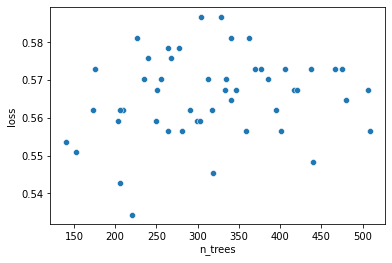

In [79]:
sns.scatterplot(data=df, x='n_trees', y='loss')
plt.show()

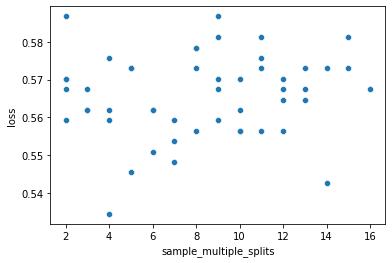

In [80]:
sns.scatterplot(data=df, x='sample_multiple_splits', y='loss')
plt.show()

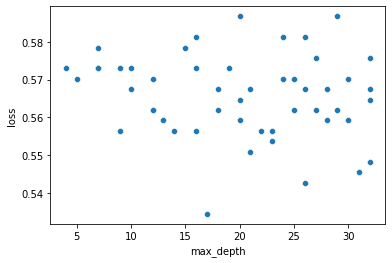

In [81]:
sns.scatterplot(data=df, x='max_depth', y='loss')
plt.show()